In [17]:
! pip install numpy h5py pandas

In [18]:
import h5py as h5  #for handling data format
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
Data_SSE  = h5.File('COMPAS_Output_SSE.h5')

In [20]:
SP_SSE = Data_SSE['SSE_System_Parameters']
print(SP_SSE['Teff'].attrs['units']) # attrs refers to attributes
print(SP_SSE['Luminosity'].attrs['units'])

b'K'
b'Lsol'


In [21]:
L_SSE = SP_SSE['Luminosity'][()]
print(L_SSE.shape)                   # number of systems in this file
print(L_SSE[:5])                    # the values of the first 3 entries
T_SSE = SP_SSE['Teff'][()]
print(T_SSE.shape)                   # number of systems in this file
print(T_SSE[:5])                    # the values of the first 3 entries

(75000,)
[ 0.44208346  5.90186228 93.60656714  2.75878624  4.24579915]
(75000,)
[ 5378.08264143  7818.78582496 13344.80882652  6819.88165121
  7305.052703  ]


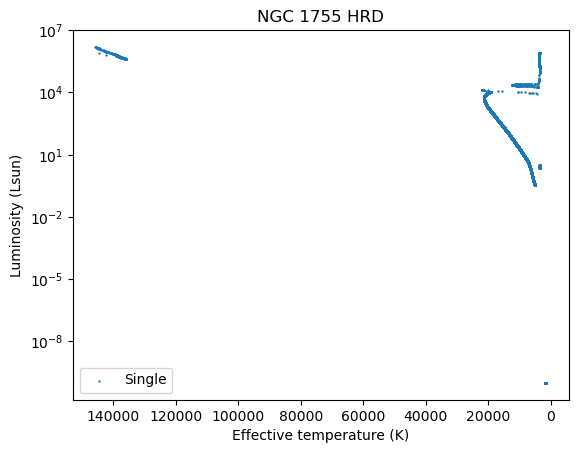

In [22]:
plt.scatter(T_SSE, L_SSE, label = 'Single', s = 0.5)
plt.gca().invert_xaxis()
plt.title('NGC 1755 HRD')
plt.xlabel('Effective temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.yscale('log')
plt.legend()


In [23]:
def restrict(df, col, lower_limit, upper_limit):
    mask = (df[col] >= lower_limit) & (df[col] <= upper_limit)
    return df[mask]

In [24]:
SSE_file = pd.DataFrame({
           'L': L_SSE,
           'logL': np.log10(L_SSE),
           'Teff': T_SSE,
           'M': SP_SSE['Mass'][()],
           'Z': SP_SSE['Metallicity@ZAMS'][()],
           'type': SP_SSE['Stellar_Type'][()]
})
SSE_file = restrict(SSE_file, 'type', 0, 1) #MS stars only

In [25]:
SSE_file = SSE_file.iloc[::2]
SSE_file = SSE_file.reset_index(drop=True)

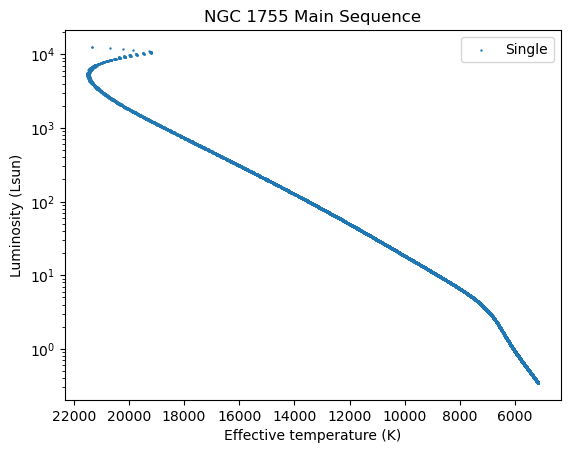

In [26]:
plt.scatter(SSE_file.Teff, SSE_file.L, label = 'Single', s = 0.5)
plt.gca().invert_xaxis()
plt.title('NGC 1755 Main Sequence')
plt.xlabel('Effective temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.yscale('log')
plt.legend()

In [27]:
SSE_file.shape

(35984, 6)

In [28]:
df = pd.read_csv('BC_table_202101_P2.csv')
df.head(3)

,logTeff,logg,F218W,F225W,F275W,F336W,F390W,F438W,F475W,F555W,...,F555W_Av20,F606W_Av20,F625W_Av20,F775W_Av20,F814W_Av20,F105W_Av20,F110W_Av20,F125W_Av20,F140W_Av20,F160W_Av20
0,3.6,0.0,-8.716149,-8.862892,-8.913703,-4.961016,-3.493491,-2.717419,-1.757311,-1.067481,...,-19.308280,-17.075062,-16.625546,-12.023130,-10.107734,-5.917497,-4.508770,-3.856155,-2.666431,-1.758023
1,3.6,0.5,-8.609341,-8.838216,-8.635061,-4.622057,-3.301807,-2.582402,-1.710106,-1.049226,...,-19.311644,-17.082409,-16.633158,-12.030067,-10.121541,-5.935500,-4.529656,-3.876964,-2.670279,-1.751570
2,3.6,1.0,-8.526805,-8.809182,-8.363065,-4.335161,-3.150630,-2.483423,-1.687547,-1.046030,...,-19.317995,-17.090355,-16.641375,-12.033483,-10.130316,-5.948132,-4.545968,-3.893304,-2.672495,-1.746036


In [29]:
def convert_to_mag(L, Teff, table, A_coeff, filter):
    count = 0
    '''
    # ref: https://www.nature.com/articles/s41550-021-01597-5#Sec2
    '''
    M_bol = 4.74 - 2.5*np.log10(np.array(L))
    M_F = np.zeros(len(M_bol))
    for i in range(len(M_bol)):
        curr_logTeff = round(np.log10(Teff[i]),2)
        if curr_logTeff < 3.60 or curr_logTeff > 4.32:
            M_F[i] = np.NaN
            count += 1
            continue
        elif filter == 'F814W':
            BC_F = table.F814W[(table.logTeff == curr_logTeff) & (table.logg == 0.0)]
        elif filter == 'F336W':
            BC_F = table.F336W[(table.logTeff == curr_logTeff) & (table.logg == 0.0)]
        M_F[i] = M_bol[i] - BC_F
    print('# of Nans: ' + str(count))
    return M_F +  A_coeff * 0.14 + 18.29 #E(B-V) + (m-M)

In [30]:
simul_mF814W_SSE = convert_to_mag(SSE_file.L, SSE_file.Teff, df, 2.04, 'F814W')
simul_mF336W_SSE = convert_to_mag(SSE_file.L, SSE_file.Teff, df, 5.16, 'F336W')

# of Nans: 382
# of Nans: 382


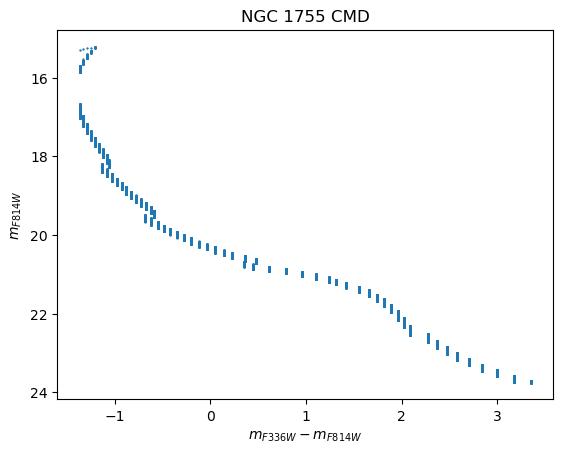

In [31]:
plt.scatter(simul_mF336W_SSE - simul_mF814W_SSE, simul_mF814W_SSE, s = 0.5)
plt.title('NGC 1755 CMD')
plt.xlabel(r'$m_{F336W}-m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.gca().invert_yaxis()
plt.ticklabel_format(useOffset=False)

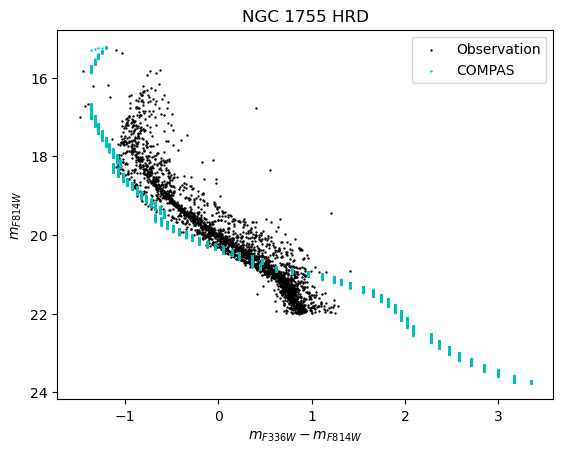

In [32]:
obs = pd.read_csv('n1755_decont.csv')
plt.scatter(obs.F336W-obs.F814W, obs.F814W, s = 0.5, c='k', label = 'Observation')
plt.scatter(simul_mF336W_SSE - simul_mF814W_SSE, simul_mF814W_SSE, s = 0.5, c='c', label = 'COMPAS')
plt.xlabel(r'$m_{F336W}-m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.gca().invert_yaxis()
plt.title('NGC 1755 HRD')
plt.legend()